This notebook plots a live graph that annotes hovered datapoints with an image of the relevant egg. It allows multiple channels and timepoints being plotted simulatneously, however plotting multiple channels is not very pretty as the different channels are not separated particularly clearly on the x axis.

Having made the longform dataframe using the TIFF to Dataframes notebook is a prerequisite.

In [2]:

import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

from PIL import Image
import numpy as np
%matplotlib widget

import random  
import pandas as pd

In [3]:
longdf = pd.read_csv('Example_Long_Dataframe.csv')

def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

In [4]:
####     create a list of arrays that represent each channel in each egg at each timepoint, only your proteins of interest!!!!! #######
####     and reorders them to how the graph is plotted                         #####

times = ["Prophase", "5.5hr"]
Proteins = ['gH2AX','Cyclin-A2']
metals = list(pd.read_csv('ExamplePanel.csv')['name'])  ###Change 'ExamplePanel' to your real panel name
listofarrays = []


ProteinIndex=[] ## loop that creates a list of the locations of your proteins of interest in the metals list (and therefore in the individual images array)
for prot in range(len(Proteins)):
    ProteinIndex.append(metals.index(Proteins[prot]))
    
    
    
for timepoint in times:
    
    multi = read_tiff(timepoint+".tiff") 
    multimask = read_tiff(timepoint+"Mask.tif")
    EggCount = multimask.shape[0] ##How many channels are in the mask, ie eggs are we going to be iterating through?
    
    for i in range(EggCount):
        mask_arr = np.array(multimask[i]) # Choose the mask 
        mask_df = pd.DataFrame(mask_arr)  # Turn the mask into a dataframe for easy mask application to the actual image
        
        for channel in ProteinIndex:
            df=pd.DataFrame(multi[channel]) 
            tightdf=df[mask_df == 255].dropna(how='all').dropna(how='all',axis=1) # Applies the mask, and drops all rows/columns that are empty
            
            listofarrays.append(tightdf.to_numpy())

####################################

eggcounts = []
for t,time in enumerate(times):
    timepointmask = read_tiff(time+"Mask.tif")
    eggcounts.append(timepointmask.shape[0])

reorderedLOA = []    

for p,prot in enumerate(Proteins):
    for t,timepoint in enumerate(times):
        for egg in range(eggcounts[t]):
            reorderedLOA.append(listofarrays[(sum(eggcounts[0:t])*len(Proteins))+(egg*len(Proteins))+p])


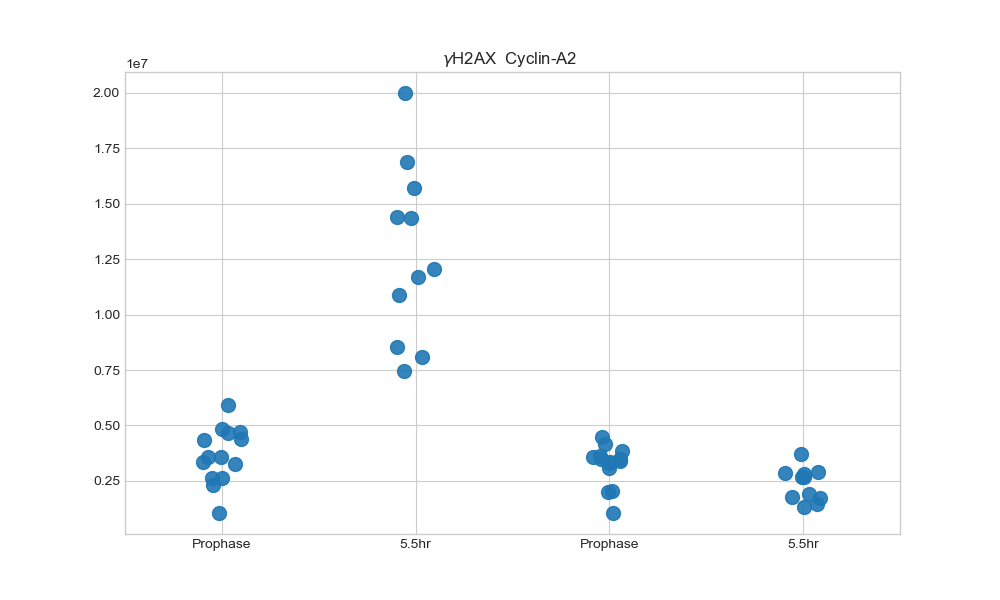

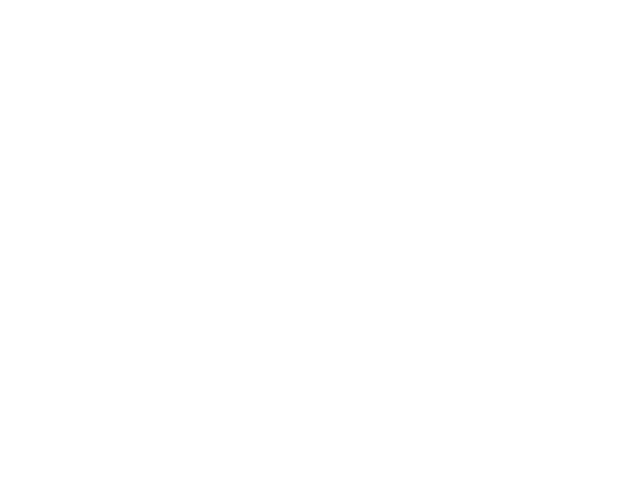

In [5]:
############   PLOT ONE PROTEIN AT A TIME, AND ANNOTE WITH IMAGE OF EGG ON HOVER ##################### Requires the above cell

               ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##

plt.style.use('seaborn-whitegrid')    # sets style since we're just using matplotlib


MultiChannelDF = longdf[(longdf["Target"] == Proteins[0])].copy() ## loop that creates DF that is longform but only your proteins of interest
pcount = 0
if len(Proteins) > 1:
    for p in range(len(Proteins)):
        if pcount > 0:
            newprotdf = longdf[longdf["Target"] == Proteins[p]].copy()
            MultiChannelDF = pd.concat([MultiChannelDF,newprotdf])
        pcount = pcount+1

ProteinIndex=[] ## loop that creates a list of the locations of your proteins of interest in the metals list (and therefore in the individual images array)
for prot in range(len(Proteins)):
    ProteinIndex.append(metals.index(Proteins[prot]))
    

           #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# Generating plottable x values

x = np.asarray(MultiChannelDF['Timepoint']) # x values are our two timepoints
y = np.asarray(MultiChannelDF['Total_Signal']) # y values are the total signal values for selected metal
z = np.asarray(MultiChannelDF['Target'])
currenttime = times[0]
currentprot = Proteins[0]
numberofprots = len(Proteins)
xcounter = 0


for j in range(len(x)): # replacing x values (timepoints) with single digit increments
    
    if (z[j] != currentprot) or (x[j] != currenttime):
        xcounter = xcounter+1
        currentprot = z[j]
        currenttime = x[j]
        x[j] = xcounter

    else:
        x[j] = xcounter
        
for k in range(len(x)): # adding jitter to X values to separate points
    x[k] = x[k] + random.uniform(-0.1,0.1)
        
    
    
              #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# Plotting the dang graph
    
             
plt.tight_layout()

arr = reorderedLOA # the following code uses the name arr for the source of data called up by the live annotation

# create figure and plot scatter
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
line, = ax.plot(x,y, ls="", marker="o",alpha=0.9, ms = 10)

              #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# Creating the annotation box

# create the annotations box
im = OffsetImage(arr[0], zoom=1,cmap='viridis')
xybox=(50., 50.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)
              
    
              #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# Hover code
        
        
def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
        ind, = line.contains(event)[1]["ind"]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(x[ind], y[ind])
        # set the image corresponding to that point
        im.set_data(arr[ind]) # the metal len multiplier accounts for the arr having all the metal tag data in it, protein index value finds the right one per egg
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)


              #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# Graph tweaks
labels = times
for t in range(len(times)):
    if t > 0:
        labels.extend(times)

    
ax.set_xticks(ticks=list(range(len(times))),minor=False,labels=labels) # replaces x number values with our good ol' timepoints



fancytitle = ''  # this replaces the lazy g in gh2ax with the actual gamma symbol
for pr in Proteins:
    if pr == 'gH2AX':
        newname = '$\gamma$'+'H2AX'
        fancytitle = fancytitle+newname+'  '
    else:
        fancytitle = fancytitle+pr+'  '
    
ax.set_title(fancytitle)

ax.set_xlim(-0.5,(len(Proteins)*2)-0.5)

plt.show()